# Atividade 1 da Disciplica de Machine Learning
## Alunos - Matrícula: 
    Gabriel Miranda - 202100011430
    Rafael Takeguma - 202100011833
    Arthur Santos   - 202000012560
## Etapa 1: Pré-processamento dos dados

Abrindo o dataset em um dataframe pandas

In [161]:
import pandas as pd

df = pd.read_csv("dataset.csv")
df.head()

,curriculum_id,student_id,centro,department_name,course_name,student_age_at_initial_period,birthday,birth_place,ingress_form,locks_number,...,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
0,122,97,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,30,1964-05-14,PORTO ALEGRE/RS,TRANSFERÊNCIA COMPULSÓRIA,0,...,100.0,CANCELADO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,1.79,4.537049,0.300,0.476704,0.300,0.530138,0.1611
1,215,167,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1980-05-11,ARACAJU/SE,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.69,4.537049,0.300,0.476704,0.367,0.530138,0.7366
2,348,285,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,19,1983-10-26,ARACAJU/SE,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.66,4.537049,0.300,0.476704,0.446,0.530138,0.8911
3,352,289,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1981-08-08,RIO DE JANEIRO/RJ,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.71,4.537049,0.300,0.476704,0.411,0.530138,0.8273
4,414,351,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1986-02-10,ARACAJU/SE,VESTIBULAR,0,...,100.0,CONCLUÍDO,CONCLUÍDO,6.55,4.537049,0.325,0.476704,0.429,0.530138,0.9132


Exibindo informações gerais sobre o dataset

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  2603 non-null   int64  
 1   student_id                     2603 non-null   int64  
 2   centro                         2603 non-null   object 
 3   department_name                2603 non-null   object 
 4   course_name                    2603 non-null   object 
 5   student_age_at_initial_period  2603 non-null   int64  
 6   birthday                       2603 non-null   object 
 7   birth_place                    2600 non-null   object 
 8   ingress_form                   2603 non-null   object 
 9   locks_number                   2603 non-null   int64  
 10  required_ch_progress           2603 non-null   float64
 11  optative_ch_progress           2603 non-null   float64
 12  curriculum_status              2603 non-null   o

Foi observado que a coluna leaving_reason, que descreve o motivo de saída do curso, possui linhas vazias. Como essa coluna foi escolhida para ser a coluna de predição, já que descreve se o aluno saiu por conclusão, abandono, etc., as linhas em que não haviamc onteúdo foram removidas.

In [163]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  1514 non-null   int64  
 1   student_id                     1514 non-null   int64  
 2   centro                         1514 non-null   object 
 3   department_name                1514 non-null   object 
 4   course_name                    1514 non-null   object 
 5   student_age_at_initial_period  1514 non-null   int64  
 6   birthday                       1514 non-null   object 
 7   birth_place                    1514 non-null   object 
 8   ingress_form                   1514 non-null   object 
 9   locks_number                   1514 non-null   int64  
 10  required_ch_progress           1514 non-null   float64
 11  optative_ch_progress           1514 non-null   float64
 12  curriculum_status              1514 non-null   o

Exibindo todas as classes da coluna leaving_reason.

In [164]:
df['leaving_reason'].unique()

array(['DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO', 'ABANDONO',
       'CONCLUÍDO',
       'Não atendeu à convocação para o Cadastro Específico conforme Edital 21/2017/PROGRAD',
       'CANCELAMENTO ESPONTÂNEO', 'CANC.. NOVO VESTIBULAR',
       'Transferência Interna', 'TRANSF.P/OUTRA IES',
       'CADASTRO CANCELADO', 'NÃO CONFIRMAÇÃO VÍNCULO'], dtype=object)

A classe 'ABANDONO', na coluna 'leaving_reason', é o que define se há ou não evasão, as restantes não representam a evasão. 

Logo, vamos gerar uma nova coluna de classe com o nome de 'abandono', onde terá valor 1, caso haja evasão (ABANDONO) e 0 caso seja qualquer outro leaving_reason.
Essa será a nossa nova coluna com as classes de predição, portanto removeremos a antiga coluna 'leaving_reason'. 

In [165]:
df['abandono'] = df['leaving_reason'].isin(['ABANDONO']).astype('int8')
df = df.drop(columns=['leaving_reason'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  1514 non-null   int64  
 1   student_id                     1514 non-null   int64  
 2   centro                         1514 non-null   object 
 3   department_name                1514 non-null   object 
 4   course_name                    1514 non-null   object 
 5   student_age_at_initial_period  1514 non-null   int64  
 6   birthday                       1514 non-null   object 
 7   birth_place                    1514 non-null   object 
 8   ingress_form                   1514 non-null   object 
 9   locks_number                   1514 non-null   int64  
 10  required_ch_progress           1514 non-null   float64
 11  optative_ch_progress           1514 non-null   float64
 12  curriculum_status              1514 non-null   o

Agora devemos observar o restante das colunas.
Exibindo um resumo das colunas numéricas do dataset.

In [166]:
df.describe()

,curriculum_id,student_id,student_age_at_initial_period,locks_number,required_ch_progress,optative_ch_progress,mc,course_mc,iepl,course_iepl,iech,course_iech,iea,abandono
count,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000
mean,2074.133421,1845.038309,21.842140,0.219287,41.029212,41.055702,4.100271,4.591109,0.445141,0.481572,0.477109,0.533039,1.541577,0.480845
std,737.974055,689.459947,5.357002,0.480414,38.778900,42.886161,2.769070,0.065437,0.213704,0.018419,0.225883,0.011215,2.098772,0.499798
min,122.000000,55.000000,16.000000,0.000000,0.000000,0.000000,0.000000,4.537049,0.300000,0.461930,0.300000,0.521000,0.000000,0.000000
25%,1505.250000,1321.000000,18.000000,0.000000,5.263158,0.000000,1.432500,4.537049,0.300000,0.461930,0.300000,0.521000,0.128925,0.000000
50%,2120.500000,1881.500000,20.000000,0.000000,27.631579,21.428571,4.530000,4.586078,0.300000,0.476704,0.332000,0.530138,0.538100,0.000000
75%,2617.250000,2351.750000,23.000000,0.000000,86.746162,100.000000,6.590000,4.697231,0.556000,0.511211,0.641500,0.551049,2.319300,1.000000
max,3923.000000,3382.000000,54.000000,2.000000,100.000000,100.000000,9.390000,4.697231,1.100000,0.511211,1.000000,0.551049,10.329000,1.000000


Inicialmente, removeremos colunas que não se mostram importantes para a predição da evasão, como: matrícula, data de nascimento, local de nascimento, id do estudante, centro e nome do departamento.
Outros campos podem ser removidos posteriormente, depois de análises mais detalhadas.

In [167]:
df = df.drop(columns=['curriculum_id', 'student_id', 'centro', 'department_name', 'birthday', 'birth_place'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   course_name                    1514 non-null   object 
 1   student_age_at_initial_period  1514 non-null   int64  
 2   ingress_form                   1514 non-null   object 
 3   locks_number                   1514 non-null   int64  
 4   required_ch_progress           1514 non-null   float64
 5   optative_ch_progress           1514 non-null   float64
 6   curriculum_status              1514 non-null   object 
 7   mc                             1514 non-null   float64
 8   course_mc                      1514 non-null   float64
 9   iepl                           1514 non-null   float64
 10  course_iepl                    1514 non-null   float64
 11  iech                           1514 non-null   float64
 12  course_iech                    1514 non-null   f

Agora, vamos analisar as colunas numéricas restantes para determinar se precisamos realizar transformações ou remoções de colunas.

In [172]:
colunas_numericas = df.drop(columns=['abandono']).columns
df[colunas_numericas].describe()

,student_age_at_initial_period,locks_number,required_ch_progress,optative_ch_progress,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
count,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000
mean,21.842140,0.219287,41.029212,41.055702,4.100271,4.591109,0.445141,0.481572,0.477109,0.533039,1.541577
std,5.357002,0.480414,38.778900,42.886161,2.769070,0.065437,0.213704,0.018419,0.225883,0.011215,2.098772
min,16.000000,0.000000,0.000000,0.000000,0.000000,4.537049,0.300000,0.461930,0.300000,0.521000,0.000000
25%,18.000000,0.000000,5.263158,0.000000,1.432500,4.537049,0.300000,0.461930,0.300000,0.521000,0.128925
50%,20.000000,0.000000,27.631579,21.428571,4.530000,4.586078,0.300000,0.476704,0.332000,0.530138,0.538100
75%,23.000000,0.000000,86.746162,100.000000,6.590000,4.697231,0.556000,0.511211,0.641500,0.551049,2.319300
max,54.000000,2.000000,100.000000,100.000000,9.390000,4.697231,1.100000,0.511211,1.000000,0.551049,10.329000


array([[<Axes: xlabel='student_age_at_initial_period', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='locks_number', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='required_ch_progress', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='optative_ch_progress', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='mc', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='course_mc', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='iepl', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='course_iepl', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='iech', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='course_iech', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='iea', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='abandono', ylabel='student_age_at_initial_period'>],
       [<Axes: xlabel='student_age_at_initial_period', ylabel=

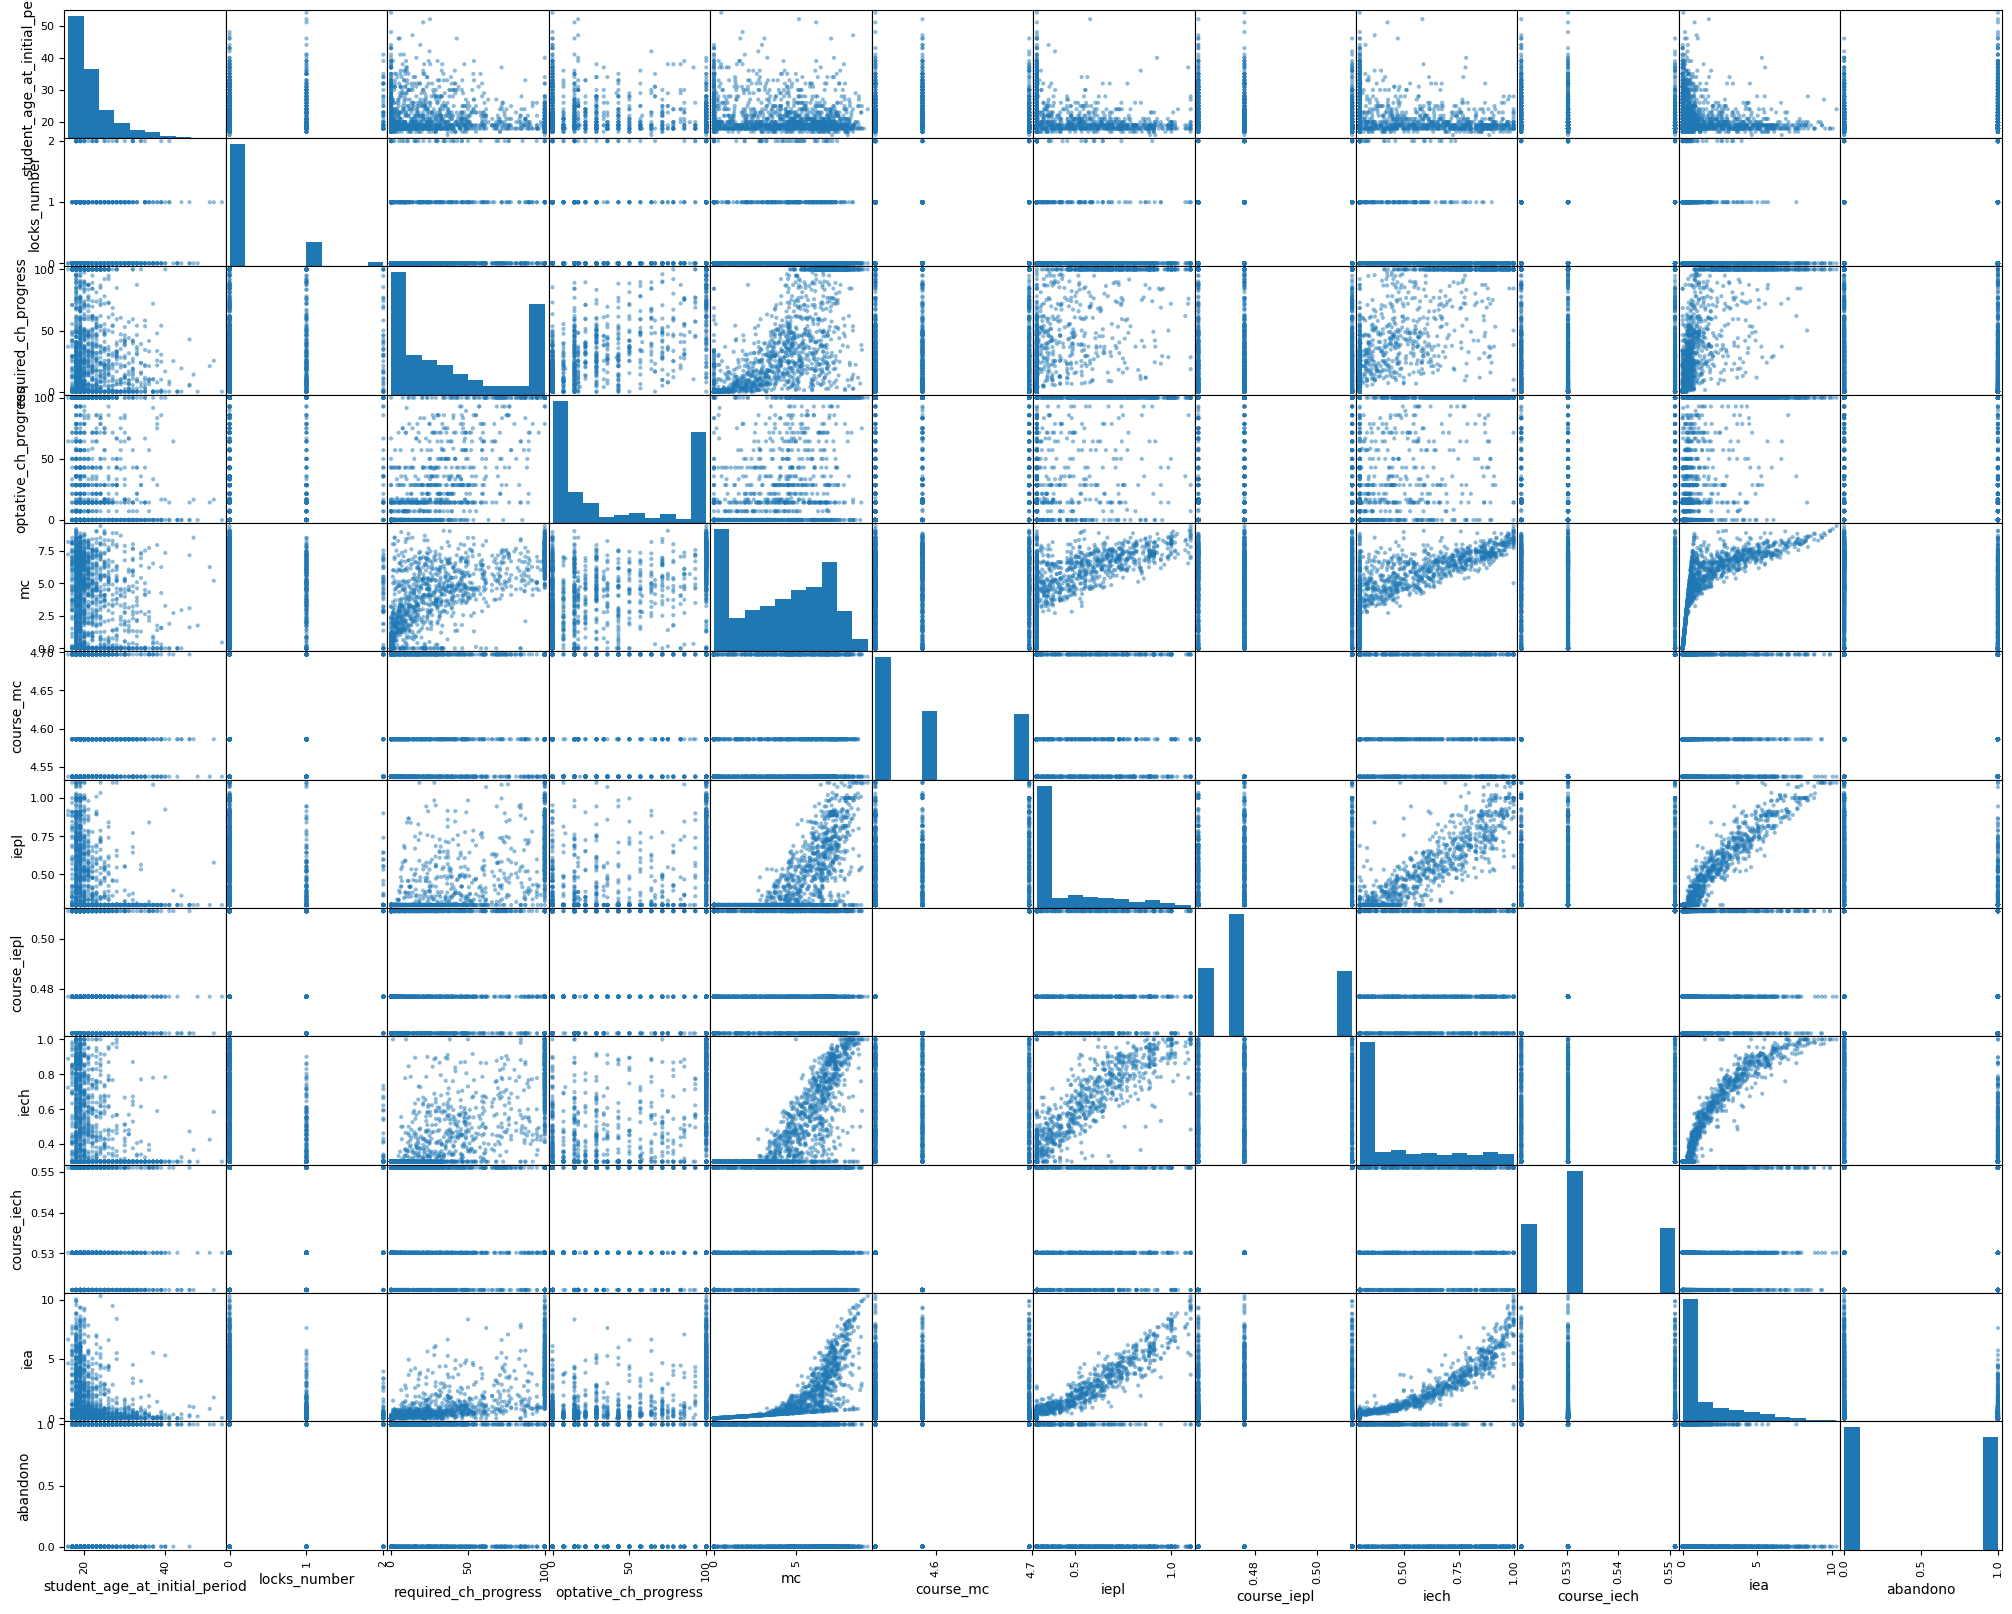

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, figsize=(25,20))

Agora, utilizamos a função hist() para vizualizar os dados numéricos em forma de histograma.

Dessa forma verificamos a distribuição dos dados e suas escalas.

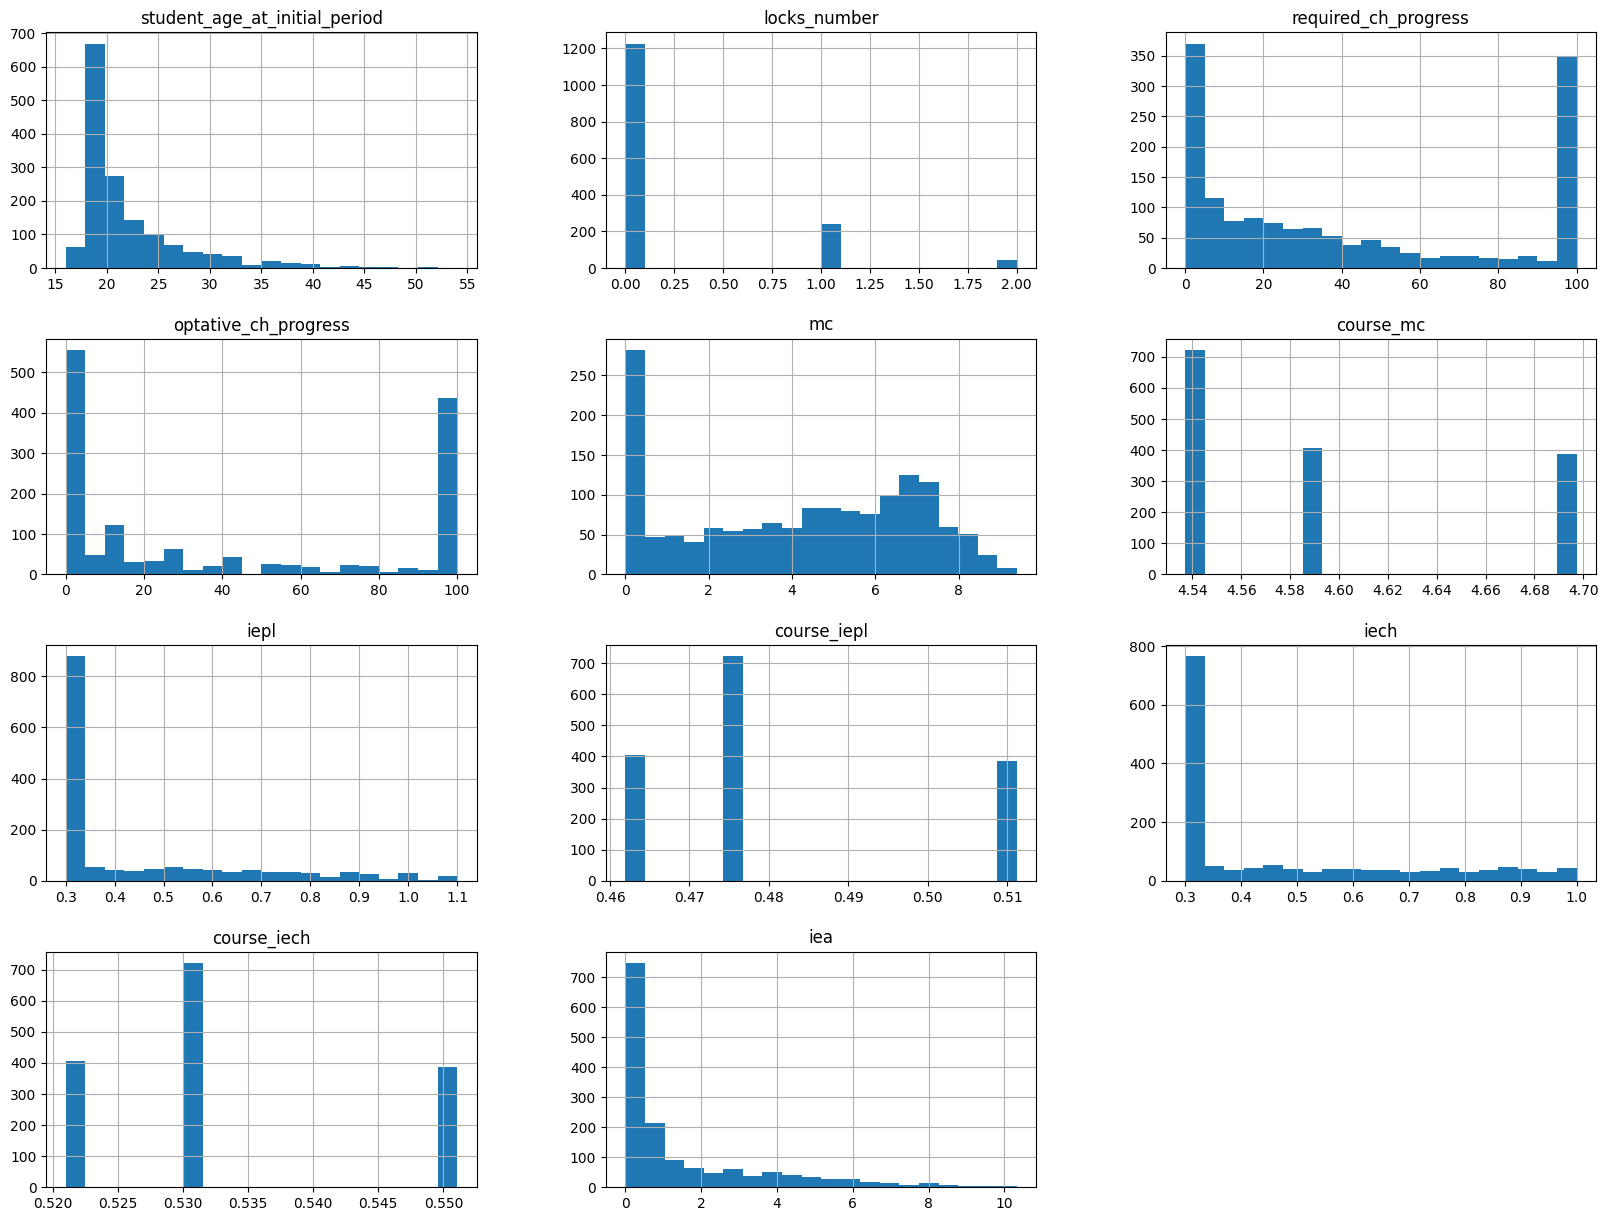

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

df[colunas_numericas].hist(bins=20, figsize=(20,15))
plt.show()

É possível observar que há uma descrepância na distibuição desses dados, com o iepl, por exemplo, indo de 0.3 até 1.1 enquanto o required_ch_progress vai de 0 a 100. Os dados nos histogramas também apresentam uma tendência a se concentrar mais à esquerda, o que pode dificultar a interpretação do modelo.
Portanto, devemos aplicar alguma técnica de normalização nesses dados.

Primeiro, separamos o dataset em treino e teste.

In [170]:
from sklearn.model_selection import train_test_split
import random
import numpy as np

# Definir a seed para garantir reprodutibilidade
random.seed(42)  # Seed do Python
np.random.seed(42)  # Seed do NumPy

#X = df.drop(columns=['leaving_reason'])
#y = df['leaving_reason']
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

### Etapa 2 - Seleção de modelo
Verificando a acuracia do RandomForestClassifier que já foi treinado

In [171]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_class = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_class)
print(f"Acurácia: {accuracy:.2f}")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_class))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_class))


ValueError: could not convert string to float: 'SISTEMAS DE INFORMAÇÃO'

### Etapa 3 - Realizando o ajuste fino (fine-tune) do modelo Random Forest Classifier
#### Grid Search
A técnica do Grid Search visa encontrar uma boa combinação dos hiperparâmetros para o melhor desempenho do modelo.
Com o GridSearchCV do Scikit-Learn, é possível passar quais hiperparâmetros pretende-se ajustar e quais valores para os mesmos pretende-se testar.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(clf, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(X_train, y_train)

c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 40, 50, 60, 70, 80, 90,
                                           100, 200, 300]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 3}

Como pode-se observar, a melhor combinação dos hiperparâmetros foi no máximo duas features usadas para escolher a melhor divisão dos dados e 30 árvores de decisão.

Verificando a importância de cada atributo.

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, X_train.columns), reverse=True)

[(0.20005164509326617, 'iea'),
 (0.14338256008944866, 'curriculum_status_CONCLUÍDO'),
 (0.13740849159302154, 'required_ch_progress'),
 (0.12912945322602443, 'optative_ch_progress'),
 (0.1219010555080725, 'iech'),
 (0.11511353527872419, 'mc'),
 (0.08847561795263348, 'student_age_at_initial_period'),
 (0.06453764125880893, 'iepl')]

### Etapa 4 - Avaliando o modelo com o Test Set

In [ ]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

acuracia = accuracy_score(y_test, final_predictions)
acuracia

0.6534653465346535

Agora vamos converter y para valores numericos e usar a regressão linear:

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalizando os dados
scaler = StandardScaler()


# Codificação de 'leaving_reason' para números
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(df['leaving_reason'])

# Separação do dataframe em features (somente numéricas) e target
X = df_encoded.drop(columns=['leaving_reason'])
y = y_numeric  # Agora 'y' é a versão numérica

# Separando os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustando e transformando os dados de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Transformando os dados de teste
X_test_scaled = scaler.transform(X_test)

# Criando o modelo
modelo = LinearRegression()

# Treinando o modelo
modelo.fit(X_train_scaled, y_train)

# Fazendo previsões
y_pred = modelo.predict(X_test_scaled)

# Calculando as métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

# Exibindo os resultados
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 5.45
Root Mean Squared Error (RMSE): 2.33
R² Score: 0.32


Agora vamos usar DecisonTreeRegressor:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Normalizando os dados
scaler = StandardScaler()

# Ajustando e transformando os dados de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Transformando os dados de teste
X_test_scaled = scaler.transform(X_test)

# Criando o modelo de árvore de decisão para regressão
modelo_tree = DecisionTreeRegressor(random_state=42)

# Ajustando o modelo aos dados de treinamento
modelo_tree.fit(X_train_scaled, y_train)

# Fazendo previsões sobre os dados de teste
y_pred_tree = modelo_tree.predict(X_test_scaled)

# Calculando as métricas de avaliação
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = mse_tree**0.5
r2_tree = r2_score(y_test, y_pred_tree)

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse_tree:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tree:.2f}")
print(f"R² Score: {r2_tree:.2f}")


Mean Squared Error (MSE): 12.59
Root Mean Squared Error (RMSE): 3.55
R² Score: -0.58


Vamos testar agora o RandomForestetRegressor:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Normalizando os dados
scaler = StandardScaler()

# Ajustando e transformando os dados de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Transformando os dados de teste
X_test_scaled = scaler.transform(X_test)

# Instanciar o modelo RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
rf_model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred_rf = rf_model.predict(X_test_scaled)

# Calcular as métricas de avaliação
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf**0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Exibir os resultados
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Random Forest - Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Random Forest - R² Score: {r2_rf:.2f}")

Random Forest - Mean Squared Error (MSE): 5.55
Random Forest - Root Mean Squared Error (RMSE): 2.36
Random Forest - R² Score: 0.31


Vamos usar o KNeighborsRegressor agora:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Normalizando os dados
scaler = StandardScaler()

# Ajustando e transformando os dados de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Transformando os dados de teste
X_test_scaled = scaler.transform(X_test)

# Instanciar o modelo KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=5)

# Treinar o modelo
knn_model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred_knn = knn_model.predict(X_test_scaled)

# Calcular as métricas de avaliação
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = mse_knn**0.5
r2_knn = r2_score(y_test, y_pred_knn)

# Exibir os resultados
print(f"KNN - Mean Squared Error (MSE): {mse_knn:.2f}")
print(f"KNN - Root Mean Squared Error (RMSE): {rmse_knn:.2f}")
print(f"KNN - R² Score: {r2_knn:.2f}")


KNN - Mean Squared Error (MSE): 5.71
KNN - Root Mean Squared Error (RMSE): 2.39
KNN - R² Score: 0.29


Agora vamos comparar os modelos:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Normalização dos dados
scaler = StandardScaler()

# Ajustando e transformando os dados de treinamento
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definindo os modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Dicionário para armazenar os resultados
results = {}

# Treinando e avaliando os modelos
for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Treinando o modelo
    y_pred = model.predict(X_test_scaled)  # Fazendo previsões
    
    # Calculando as métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    # Armazenando os resultados
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R² Score": r2
    }

# Exibindo os resultados
for name, metrics in results.items():
    print(f"Modelo: {name}")
    print(f"Mean Squared Error (MSE): {metrics['MSE']:.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")
    print(f"R² Score: {metrics['R² Score']:.2f}")
    print("-" * 50)


Modelo: Linear Regression
Mean Squared Error (MSE): 5.45
Root Mean Squared Error (RMSE): 2.33
R² Score: 0.32
--------------------------------------------------
Modelo: Random Forest
Mean Squared Error (MSE): 5.55
Root Mean Squared Error (RMSE): 2.36
R² Score: 0.31
--------------------------------------------------
Modelo: K-Nearest Neighbors
Mean Squared Error (MSE): 5.71
Root Mean Squared Error (RMSE): 2.39
R² Score: 0.29
--------------------------------------------------
Modelo: Decision Tree
Mean Squared Error (MSE): 12.59
Root Mean Squared Error (RMSE): 3.55
R² Score: -0.58
--------------------------------------------------


De acordo com os resultados o modelo com o melhor resultado foi o RandomForestRegressor.